In [98]:
import json
from collections import Counter
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import shelve

The original data is too large to be uploaded onto GitHub. Thus, the pre-processing and extracting of data were conducted locally with the following code. The original data can be retrived from [Yelp Dataset](https://www.yelp.com/dataset/challenge). We extract a subset from it and save the data we worked with in the "data" folder in this repository.

In [2]:
# the local path of JSON files that needed
json_business_path='../dataset/business.json'
json_review_path='../dataset/review.json'

In [3]:
# extract business information
business_contents=[]
with open(json_business_path) as fin:
    for line in fin:
        line=json.loads(line)
        business_contents.append(line)

As we can see below, the data contains business information from different states and different business types. Among the most popular locations and business types, we focus on restaurants at Ohio.

In [4]:
# In order to control the scope the project, we take OH state, 10930 businesses
state=[]
for line in business_contents:
    state.append(line['state']) 
# the 10 most popular locations
Counter(state).most_common(10)

[('AZ', 47376),
 ('NV', 30571),
 ('ON', 26520),
 ('NC', 11299),
 ('OH', 10930),
 ('PA', 8916),
 ('QC', 7273),
 ('WI', 4190),
 ('EDH', 3561),
 ('BW', 3071)]

In [5]:
# we focus on Restaurants in OH, around 4513 businesses
cat_of_business=[]
for line in business_contents:
    if line['state']=='OH':
        try:
            cat_of_business.extend(line['categories'])
        except:
            next 
    
# The 10 most popular business types,focus on 'Restaurants'
Counter(cat_of_business).most_common(10)

[('Restaurants', 4513),
 ('Food', 1916),
 ('Shopping', 1628),
 ('Nightlife', 1180),
 ('Bars', 1083),
 ('Beauty & Spas', 930),
 ('American (Traditional)', 891),
 ('Automotive', 738),
 ('Pizza', 706),
 ('Sandwiches', 677)]

In [6]:
# we have 4513 restaurants in OH to be reseaerched
OH_Restaurants=[]
for line in business_contents:
    if (line['state']=='OH') and ('Restaurants' in line['categories']):
        OH_Restaurants.append(line)
print('we will research %d restaurants in OH'%len(OH_Restaurants))

we will research 4513 restaurants in OH


For the convenience of research and reproducibility, we will save the data that extracted from the original JSON data into data frames and use them for future analyis and statistical modeling.


In [7]:
# we need to keep those columns
res_col=['state','city','address','name','business_id','stars','review_count','categories']
restaurants=json_normalize(OH_Restaurants)[res_col]

In [8]:
# a glimpse of the restaurant
restaurants.head()

,state,city,address,name,business_id,stars,review_count,categories
0,OH,Painesville,1 S State St,Sidewalk Cafe Painesville,Bl7Y-ATTzXytQnCceg5k6w,3.0,26,"[American (Traditional), Breakfast & Brunch, R..."
1,OH,Northfield,10430 Northfield Rd,Zeppe's Pizzeria,7HFRdxVttyY9GiMpywhhYw,3.0,7,"[Pizza, Caterers, Italian, Wraps, Event Planni..."
2,OH,Mentor,9209 Mentor Ave,Firehouse Subs,lXcxSdPa2m__LqhsaL9t9A,3.5,9,"[Restaurants, Sandwiches, Delis, Fast Food]"
3,OH,Cleveland,13181 Cedar Rd,Richie Chan's Chinese Restaurant,Pawavw9U8rjxWVPU-RB7LA,3.5,22,"[Chinese, Restaurants]"
4,OH,Northfield,134 E Aurora Rd,Romeo's Pizza,RzVHK8Jfcy8RvXjn_z3OBw,4.0,4,"[Restaurants, Pizza]"


In [9]:
restaurants.shape

(4513, 8)

There are a lot of business reviews, when we extract them from JSON file, we only extract those reviews which are for the restaurants in our sample.

In [35]:
# extract review information
review_contents=[]
with open(json_review_path) as fin:
    for line in fin:
        line=json.loads(line)
        if line['business_id'] in list(restaurants.business_id):
            review_contents.append(line)

In [66]:
# save all the reviews in Ohio
with shelve.open('../dataset/ohio_all_reviews') as db:
    db['reviews'] = review_contents

In [11]:
# total 154764 reviews on 4513 restaurants
len(review_contents)
# convert into data frame
reviews=json_normalize(review_contents)

We'd like to remove restaurant with too few reviews. We see that there are some restaurants which have few reviews, so we only keep restaurants which have more than 100 reviews.

In [12]:
reviews.business_id.value_counts().describe()

count    4513.000000
mean       34.292932
std        57.777458
min         3.000000
25%         6.000000
50%        15.000000
75%        39.000000
max       896.000000
Name: business_id, dtype: float64

In [13]:
# only keep the restaurants which have more than 100 reviews
keep_busID=reviews.business_id.value_counts().index[reviews.business_id.value_counts()>100]
reviews_keep=reviews.loc[reviews.business_id.isin(keep_busID),:]

In [50]:
reviews_keep.business_id.value_counts().describe()

count    316.000000
mean     190.575949
std      122.290224
min      101.000000
25%      117.750000
50%      149.000000
75%      206.250000
max      896.000000
Name: business_id, dtype: float64

As we can see in the follow plot, the range of reviews per restaurant is [100,900] after we filter the data set. 

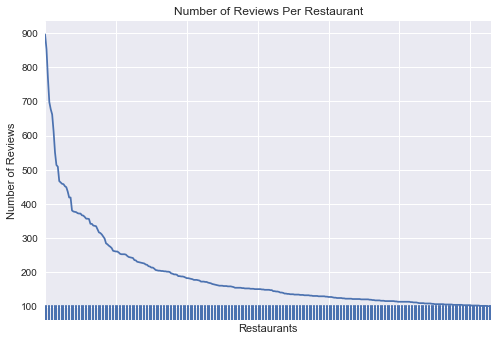

In [174]:
# plot the restaurant on x axis and number of reviews on y axis
reviews_keep.business_id.value_counts().plot()
plt.xlabel('Restaurants')
plt.ylabel('Number of Reviews')

n_obs=len(reviews_keep.business_id.unique())
sns.rugplot(np.arange(0,n_obs,1))

plt.tick_params(axis='x',labelbottom='off')
plt.title('Number of Reviews Per Restaurant')
plt.show()

plt.savefig('./fig/NumberOfReviewsPerRestaurant.png')

As we can see in th following table, the distribution of mean star rating for restaurants is skewed to the left with most restaurants having the mean star ratings in the range between 3 and 4. There are few restaurants which have earned mean ratings less than 2. 

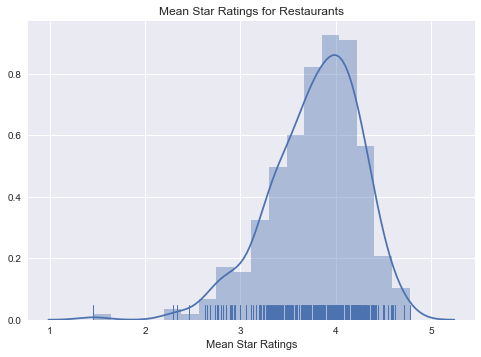

In [173]:
# the mean star rating for restaurants
sns.distplot(reviews_keep.groupby('business_id').mean()['stars'],rug=True)
plt.xlabel('Mean Star Ratings')
plt.title('Mean Star Ratings for Restaurants')
plt.show()

plt.savefig('./fig/MeanRatings.png')

In [57]:
# save to csv
reviews_keep.to_csv('reviews.csv')
restaurants.to_csv('restaurant.csv')